# Finetuning GPT-2-large with bitsandbytes

Link to the library: https://github.com/facebookresearch/bitsandbytes

Paper: https://arxiv.org/pdf/2110.02861.pdf

Awesome video explanation, highly recommended (also can be found in official repository): https://www.youtube.com/watch?v=o-YBDTqX_ZU

### Main idea 
__Let's quantize optimizator statistics to 8bits and store them this way.__

There are also several modifications.
- The quantization is __blockswise__: each tensor is split into pieces (~2000 values) and quantized indepedently. This way we __isolate outliers__ and also __keep the maximal values in each block precisely__, which is good since the maximal values are usualy the most important.
- Small tensors like biases in linear layers and layernorm parameters are not quantized, since their quality degrades significantly while the memory savings are minor.
- Authors use Dynamic Tree quantization.
- Authors propose stable embedding layers.

### Scheme of 8-bit optimizer

![image.png](8_bit_optimizer_scheme.png)
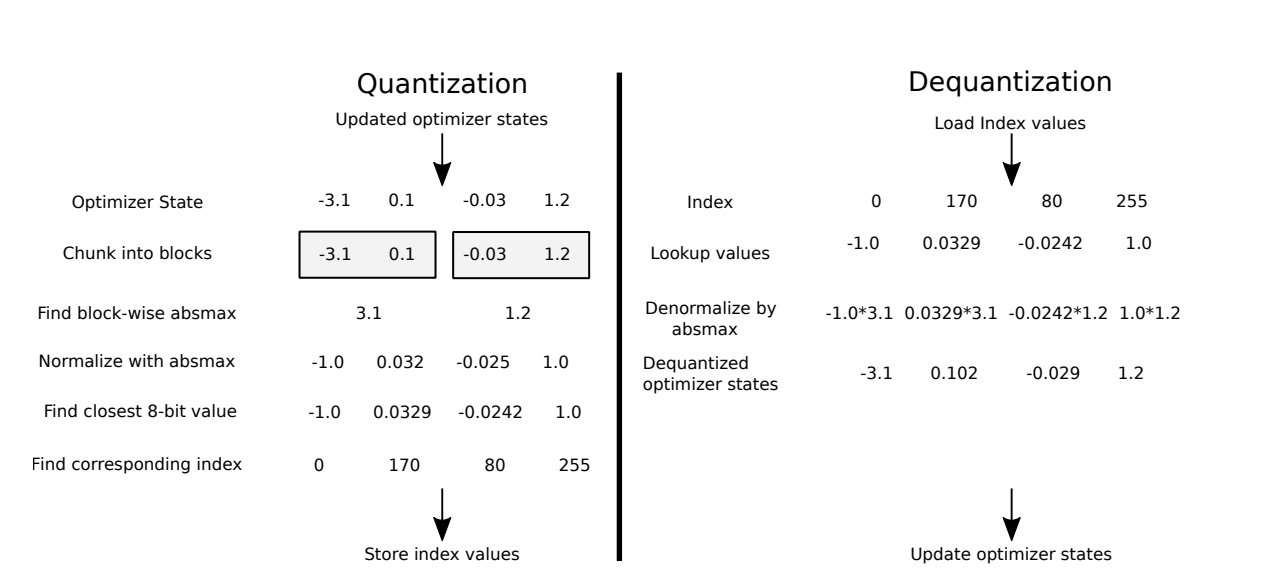

### Dynamic tree quantization

![image.png](Dynamic_tree_quantization.png)

First bit is sign bit. The number of subsequent zero bits indicates the magnitude of exponent.
The first bit set to one indicates, that all following values are reserved for linear quantization.
Compared to linear quantization, dynamic tree quantization has better absolute and relative quantization errors for non-uniform distributions.

This quantization is defined for numbers in range [-1, 1], that's why we normalize, using absmax.
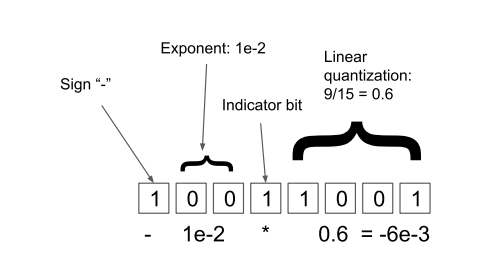

### Stable embedding layers

Authors propose stable embedding layers. For that, they 

1. use Xavier initialization
2. add a LayerNorm before adding position embeddings

This allows to avoid big gradient variations and to quantize more aggressively.

They use 32-bit dequantized statistics to update embedding layer, and the rest is updated in standard precision (usually 16 bit).

## Practice

In [1]:
import datasets
import transformers

import numpy as np
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc

plt.rcParams["figure.figsize"] = 10, 7

torch.manual_seed(21)
np.random.seed(21)

### Install bitsandbytes

In [2]:
torch.version.cuda

'11.0'

In [3]:
# Change last three digits if your cuda version is different
!pip install --user bitsandbytes-cuda110

     |████████████████████████████████| 3.3 MB 923 kB/s            


In [4]:
# Check if installation is correct
!wget https://gist.githubusercontent.com/TimDettmers/1f5188c6ee6ed69d211b7fe4e381e713/raw/4d17c3d09ccdb57e9ab7eca0171f2ace6e4d2858/check_bnb_install.py && python check_bnb_install.py

--2022-04-09 15:30:21--  https://gist.githubusercontent.com/TimDettmers/1f5188c6ee6ed69d211b7fe4e381e713/raw/4d17c3d09ccdb57e9ab7eca0171f2ace6e4d2858/check_bnb_install.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327 [text/plain]
Saving to: ‘check_bnb_install.py’

check_bnb_install.p 100%[===================>]     327  --.-KB/s    in 0s      

2022-04-09 15:30:22 (12.9 MB/s) - ‘check_bnb_install.py’ saved [327/327]

SUCCESS!
Installation was successful!


In [5]:
import bitsandbytes as bnb

### Load model and tokenizer

In [6]:
model_name = 'gpt2-large'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
model = transformers.GPT2LMHeadModel.from_pretrained(model_name).cuda()

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.02G [00:00<?, ?B/s]

In [7]:
# There is no pad token by default
tokenizer.pad_token = tokenizer.eos_token

# To save memory 
model.gradient_checkpointing_enable()

# doesn't work with gradient checkpointing
model.config.use_cache = False

### Prepare experiments configuration

In [8]:
class DotDict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


config = DotDict({
    "batch_size": 8,
    "minibatch_size": 2,
    "test_batch_size": 16,
    "device": "cuda:0",
    "n_steps": 32,
    "lr": 3e-6,
})

### Data preparation

In [9]:
data = datasets.load_dataset("wikitext", "wikitext-2-v1")

def tokenize_function(examples):
    """
    Tokenizes inputs and adds labels for causal language modeling task.
    """
    tokenized = tokenizer(examples['text'], truncation=True, max_length=512, padding=True, pad_to_multiple_of=512, return_tensors='np')
    eos_id = tokenizer(tokenizer.eos_token)["input_ids"][0]
    last = np.full((tokenized['input_ids'].shape[0],1), eos_id)
    tokenized['labels'] = np.concatenate((tokenized['input_ids'][:, 1:], last), axis=1)
    return tokenized

processed_data = data.map(tokenize_function, batched=True)
processed_data = processed_data.remove_columns(['text'])
processed_data.set_format('torch')

processed_data

Downloading:   0%|          | 0.00/2.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.48M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wikitext downloaded and prepared to /root/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

DatasetDict({
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 3760
    })
})

In [10]:
collator = transformers.DataCollatorWithPadding(tokenizer)

minibatch_size = config.minibatch_size

train_loader = torch.utils.data.DataLoader(processed_data['train'], shuffle=True, batch_size=minibatch_size, collate_fn=collator)
val_loader = torch.utils.data.DataLoader(processed_data['validation'], batch_size=minibatch_size, collate_fn=collator)

# Take several examples and fix them. Will be used to track the model progress
test_loader = torch.utils.data.DataLoader(processed_data['test'].select(range(config.test_batch_size)), batch_size=minibatch_size, collate_fn=collator)

### Train loop

In [11]:
def train_one_epoch(model, opt, train_loader, test_loader, config):
    update_freq = config.batch_size // config.minibatch_size

    model.train()

    test_batch_losses = []

    for step, batch in enumerate(tqdm(train_loader, desc="Batch")):
        batch = batch.to(config.device)

        # Use amp to speed up the computations
        with torch.cuda.amp.autocast():
            outputs = model(**batch)
            
            # It we were not using gradient accumulation, the loss would be scaled by batch_size during averaging.
            # But now it is scaled by minibatch_size, so we should adjust for that before backward.
            (outputs.loss / update_freq).backward()

        if step % update_freq == 0 and step != 0:
            opt.step()
            opt.zero_grad()

            with torch.no_grad():
                loss = 0

                with torch.cuda.amp.autocast():
                    for test_batch in test_loader:
                        test_batch = test_batch.to(config.device)
                        outputs = model(**test_batch)
                        loss += outputs.loss.item() / update_freq

                print(f"Loss on test batch: {loss:.3f}")
                test_batch_losses.append(loss)


        # Stop after predefined number of steps if n_steps is specified
        if config.n_steps is not None and step == config.n_steps:
            break
    
    return test_batch_losses

### Regular Adam

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=config.lr)

In [13]:
gc.collect()

torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.synchronize()

/opt/conda/lib/python3.7/site-packages/torch/cuda/memory.py:263: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  FutureWarning)


In [14]:
%%time
test_batch_losses = train_one_epoch(model, opt, train_loader, test_loader, config)

Batch:   0%|          | 0/18359 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


Loss on test batch: 18.042
Loss on test batch: 15.228
Loss on test batch: 12.785
Loss on test batch: 10.727
Loss on test batch: 8.937
Loss on test batch: 7.367
Loss on test batch: 6.225
Loss on test batch: 5.477
CPU times: user 51.6 s, sys: 15.6 s, total: 1min 7s
Wall time: 1min 8s


In [15]:
naive_peak_memory_gb = torch.cuda.max_memory_allocated() / 2 ** 30
print(f"Peak memory usage: {naive_peak_memory_gb:.1f} Gb")

Peak memory usage: 14.0 Gb


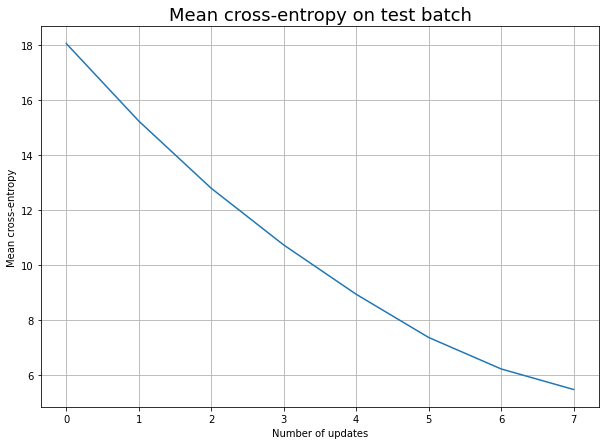

In [16]:
plt.plot(range(len(test_batch_losses)), test_batch_losses)
plt.xlabel("Number of updates")
plt.ylabel("Mean cross-entropy")
plt.title("Mean cross-entropy on test batch", fontsize=18)
plt.grid()
plt.show()

In [17]:
del model, opt

gc.collect()

3325

### 8 bit Adam

In [18]:
model = transformers.GPT2LMHeadModel.from_pretrained(model_name)

model.gradient_checkpointing_enable()
model.config.use_cache = False
model = model.cuda()

In [19]:
opt = bnb.optim.Adam8bit(model.parameters(), lr=config.lr)

In [20]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.synchronize()

In [21]:
%%time
bnb_test_batch_losses = train_one_epoch(model, opt, train_loader, test_loader, config)

Batch:   0%|          | 0/18359 [00:00<?, ?it/s]

Loss on test batch: 18.451
Loss on test batch: 15.610
Loss on test batch: 13.034
Loss on test batch: 11.175
Loss on test batch: 8.998
Loss on test batch: 7.386
Loss on test batch: 6.190
Loss on test batch: 5.338
CPU times: user 51 s, sys: 15.2 s, total: 1min 6s
Wall time: 1min 6s


In [22]:
bnb_peak_memory_gb = torch.cuda.max_memory_allocated() / 2 ** 30
print(f"Naive peak memory usage: {naive_peak_memory_gb:.1f} Gb")
print(f"Bnb peak memory usage: {bnb_peak_memory_gb:.1f} Gb")

Naive peak memory usage: 14.0 Gb
Bnb peak memory usage: 9.7 Gb


Model ~ 3 Gb

Statistics ~ 6 Gb

Quantized statistics ~ 1.5 Gb

Expected profit ~ 4.5 Gb

Real profit: 4.3 Gb


Feel the difference: without bitsandbytes you wouldn't fit it in Tesla K80, which is what you get in Google Colab.

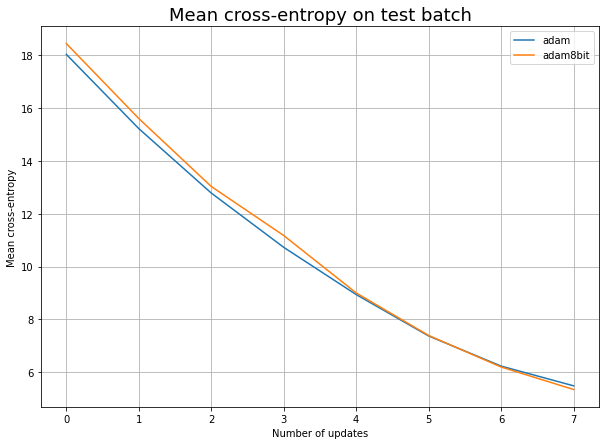

In [23]:
plt.plot(range(len(test_batch_losses)), test_batch_losses, label="adam")
plt.plot(range(len(bnb_test_batch_losses)), bnb_test_batch_losses, label="adam8bit")

plt.xlabel("Number of updates")
plt.ylabel("Mean cross-entropy")
plt.title("Mean cross-entropy on test batch", fontsize=18)
plt.grid()
plt.legend()
plt.show()

__Note__: learning rate matters. Adam performs okay with 5e-5, while Adam8bit starts to feel dizzy.

In [24]:
del model, opt

gc.collect()

3682

### 8 bit Adam with stable embeddings

In [25]:
model = transformers.GPT2LMHeadModel.from_pretrained(model_name)

model.gradient_checkpointing_enable()
model.config.use_cache = False

In [26]:
vocab_size, emb_dim = model.transformer.wte.weight.shape
stable_wte = bnb.nn.StableEmbedding(vocab_size, emb_dim, _weight=model.transformer.wte.weight)
model.transformer.wte = stable_wte

model = model.cuda()

In [27]:
opt = bnb.optim.Adam8bit(model.parameters(), lr=config.lr)

In [28]:
torch.cuda.empty_cache()
torch.cuda.reset_max_memory_allocated()
torch.cuda.synchronize()

In [29]:
%%time
stable_bnb_test_batch_losses = train_one_epoch(model, opt, train_loader, test_loader, config)

Batch:   0%|          | 0/18359 [00:00<?, ?it/s]

Loss on test batch: 12.851
Loss on test batch: 11.302
Loss on test batch: 9.818
Loss on test batch: 8.689
Loss on test batch: 7.623
Loss on test batch: 6.383
Loss on test batch: 5.374
Loss on test batch: 4.542
CPU times: user 51.1 s, sys: 15 s, total: 1min 6s
Wall time: 1min 6s


In [30]:
stable_bnb_peak_memory_gb = torch.cuda.max_memory_allocated() / 2 ** 30
print(f"Naive peak memory usage: {naive_peak_memory_gb:.1f} Gb")
print(f"Bnb peak memory usage: {bnb_peak_memory_gb:.1f} Gb")
print(f"Stable bnb peak memory usage: {stable_bnb_peak_memory_gb:.1f} Gb")

Naive peak memory usage: 14.0 Gb
Bnb peak memory usage: 9.7 Gb
Stable bnb peak memory usage: 10.7 Gb


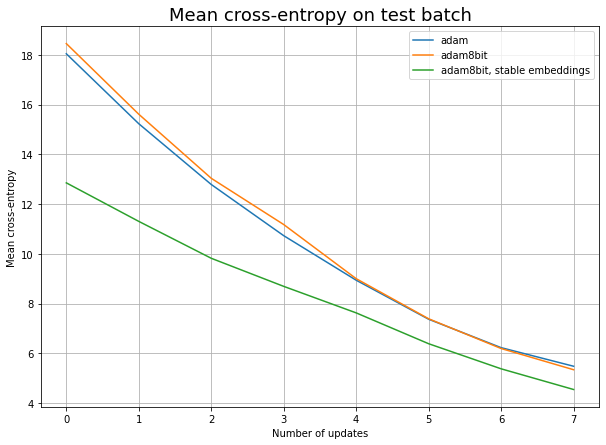

In [31]:
plt.plot(range(len(test_batch_losses)), test_batch_losses, label="adam")
plt.plot(range(len(bnb_test_batch_losses)), bnb_test_batch_losses, label="adam8bit")
plt.plot(range(len(stable_bnb_test_batch_losses)), stable_bnb_test_batch_losses, label="adam8bit, stable embeddings")


plt.xlabel("Number of updates")
plt.ylabel("Mean cross-entropy")
plt.title("Mean cross-entropy on test batch", fontsize=18)
plt.grid()
plt.legend()
plt.show()